In [2]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

import warnings
warnings.filterwarnings("ignore")

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
data = pd.read_csv("data/app.csv", sep=";")
df = data.copy()
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df = df.asfreq("H")

In [4]:
def print_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mape = mean_absolute_percentage_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}")
    print(f"RMSE: {rmse:.2f}")

def plot_preds_vs_true(ser, preds):
    axs = ser.plot(color='0.25',subplots=True, sharex=True, label='true')
    axs = preds.plot(color='C0',subplots=True, sharex=True, ax=axs, label='preds')
    plt.legend()

def create_lag_features(df, col_name, lags, steps):
    df = df.copy()
    for i in range(1, lags+1):
        df[f"{col_name}_(t-{i})"] = df[col_name].shift(i)
    for i in range(1, steps+1):
        df[f"{col_name}_(t+{i})"] = df[col_name].shift(-i)
    df = df.dropna()
    return df

def ts_train_test_split(X, y, test_size):
    idx_train, idx_test = train_test_split(X.index, test_size=test_size, shuffle=False)

    X_train, y_train = X.loc[idx_train, :], y.loc[idx_train, :]
    X_test, y_test = X.loc[idx_test, :], y.loc[idx_test, :]

    return X_train, y_train, X_test, y_test

In [5]:
TEST_SIZE = int(169*0.15)
TEST_SIZE

25

In [6]:
y = create_lag_features(df, "users", 0, 5)
y = y.drop(["sessions", "newusers", "crashes"], axis=1)
print(y.shape)

(164, 6)


In [7]:
# trend+seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    drop=True,
    # fourier=2
)

X = dp.in_sample()

In [9]:
X_train, y_train, X_test, y_test = ts_train_test_split(X, y, TEST_SIZE)

In [10]:
model_trend_season = LinearRegression(fit_intercept=False)
model_trend_season.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model_trend_season.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)

y_pred = pd.DataFrame(
    model_trend_season.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)

In [11]:
pd.DataFrame(
    model_trend_season.predict(X),
    index=y.index,
    columns=y.columns
)

,users,users_(t+1),users_(t+2),users_(t+3),users_(t+4),users_(t+5)
time,,,,,,
2018-12-22 09:00:00,69.848510,70.268756,70.369065,69.985612,69.299897,68.471120
2018-12-22 10:00:00,69.891577,70.305420,70.401564,70.018768,69.337048,68.515903
2018-12-22 11:00:00,69.934644,70.342084,70.434063,70.051924,69.374199,68.560686
2018-12-22 12:00:00,69.977711,70.378748,70.466562,70.085080,69.411350,68.605469
2018-12-22 13:00:00,70.020778,70.415412,70.499062,70.118236,69.448501,68.650252
...,...,...,...,...,...,...
2018-12-29 00:00:00,76.696188,76.098306,75.536440,75.257429,75.206890,75.591626
2018-12-29 01:00:00,76.739256,76.134970,75.568940,75.290585,75.244041,75.636409
2018-12-29 02:00:00,76.782323,76.171634,75.601439,75.323741,75.281192,75.681192


In [12]:
mae_list = []

for i in range(y_test.shape[0]):
    mae_list.append(mean_absolute_error(y_test.iloc[i,:], y_pred.iloc[i,:]))
print(f"Average mae is {np.array(mae_list).mean():.2f}")

Average mae is 25.50


In [14]:
# xgboost
# we need to arrange the df as long format, but first transform crashes column to a
# categorical column where 0 means no crashes and 1 means crashes happened
df["crashes"] = np.where(df["crashes"]>0, 1, 0)

#we will use sessions and newusers columns and also last 24 hours
df_xgb = create_lag_features(df, "users", 24, 5)

In [15]:
y_xgb = df_xgb

In [16]:
targets = df_xgb.columns[df_xgb.columns.str.contains(pat="t\+")].to_list()
targets.insert(0, "users")

y_xgb = df_xgb[targets]
X_xgb = df_xgb.drop(targets, axis=1)

In [17]:
xgb_train_end_index = y_train.index[-1]

y_xgb_train = y_xgb.loc[:xgb_train_end_index,:]
y_xgb_test = y_xgb.loc[xgb_train_end_index+dt.timedelta(hours=1):,:]

X_xgb_train = X_xgb.loc[:xgb_train_end_index,:]
X_xgb_test = X_xgb.loc[xgb_train_end_index+dt.timedelta(hours=1):,:]

In [18]:
X_xgb_train.shape, X_xgb_test.shape, X_xgb.shape

((115, 27), (25, 27), (140, 27))

In [19]:
xgb_train_first_index = y_xgb_train.index[0]

y_fit_xgb = y_fit.loc[xgb_train_first_index:]

In [20]:
y_resid_train = y_xgb_train - y_fit_xgb
y_resid_test = y_xgb_test - y_pred

In [21]:
xgboost = MultiOutputRegressor(xgb.XGBRegressor(random_state=42))
xgboost.fit(X_xgb_train, y_resid_train)
resid_preds = pd.DataFrame(
    xgboost.predict(X_xgb_test), 
    index=X_xgb_test.index, 
    columns=y_resid_test.columns)


In [22]:
mae_list = []

for i in range(y_resid_test.shape[0]):
    mae_list.append(mean_absolute_error(y_resid_test.iloc[i,:], resid_preds.iloc[i,:]))
print(f"Average mae is {np.array(mae_list).mean():.2f}")

Average mae is 10.98


In [23]:
y_final_preds = resid_preds + y_pred

In [24]:
mae_list = []

for i in range(y_final_preds.shape[0]):
    mae_list.append(mean_absolute_error(y_test.iloc[i,:], y_final_preds.iloc[i,:]))
print(f"Average mae is {np.array(mae_list).mean():.2f}")

Average mae is 10.98


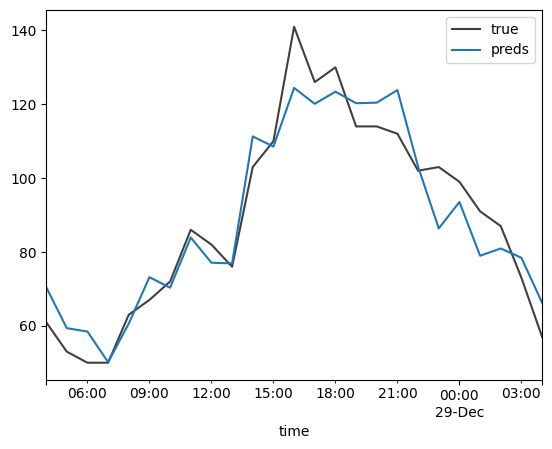

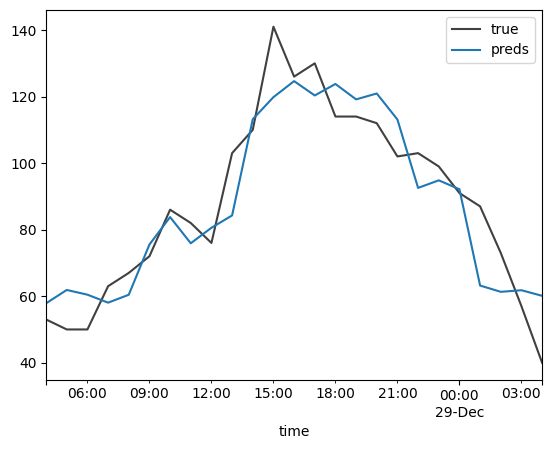

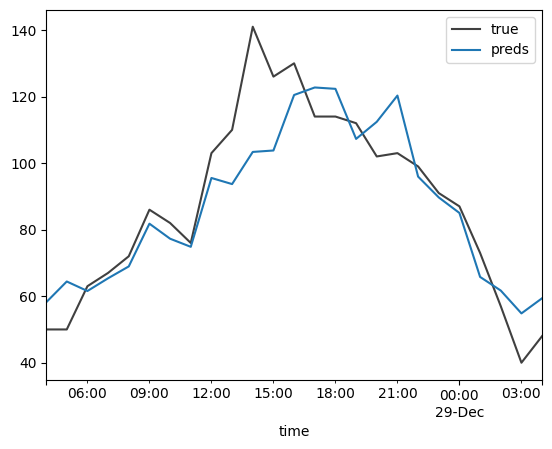

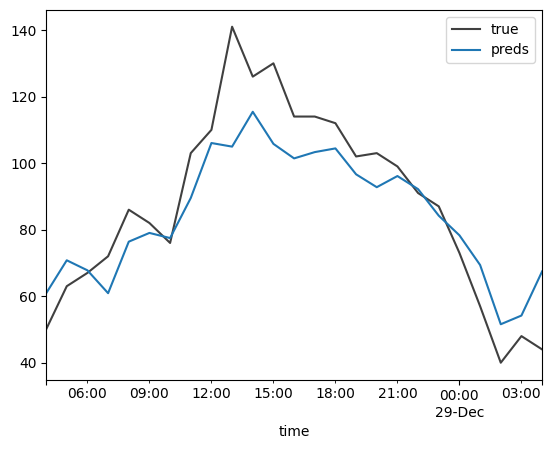

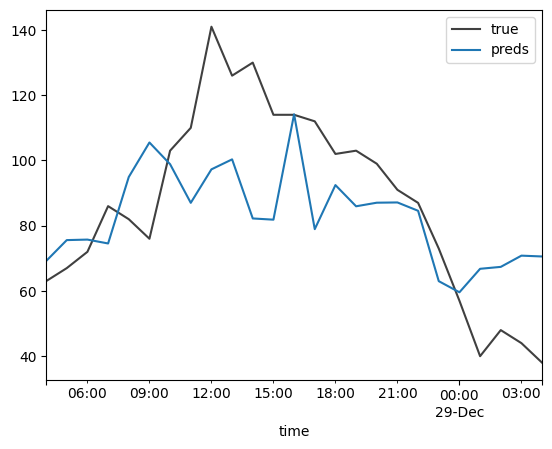

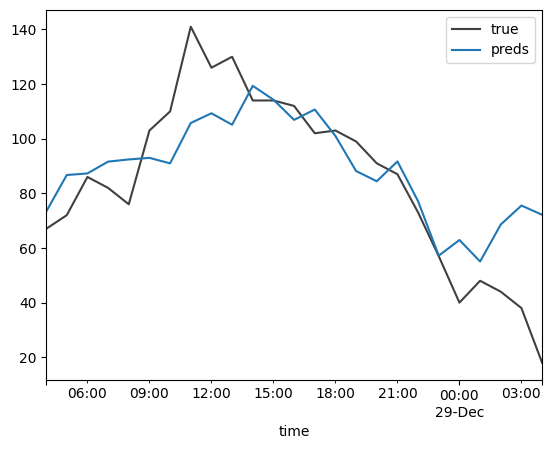

In [25]:
for i in range(y_test.shape[1]):
    plot_preds_vs_true(y_test.iloc[:,i], y_final_preds.iloc[:,i])
    plt.show()

In [26]:
#optimization
import optuna


VAL_SIZE = 24
X_xgb_train_opt = X_xgb_train.iloc[:X_xgb_train.shape[0]-VAL_SIZE,:]
X_xgb_val = X_xgb_train.iloc[-VAL_SIZE:,:]
y_xgb_train_opt = y_resid_train.iloc[:X_xgb_train.shape[0]-VAL_SIZE,:]
y_xgb_val = y_resid_train.iloc[-VAL_SIZE:,:]

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 10, 1000),
        'max_depth' : trial.suggest_int('max_depth', 2, 50),
        'eta': trial.suggest_float('eta', 0.001, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1)
    }

    reg = MultiOutputRegressor(xgb.XGBRegressor(
                               **params, 
                               random_state=42)).fit(X_xgb_train_opt, y_xgb_train_opt)
    preds_opt = pd.DataFrame(
        reg.predict(X_xgb_val), 
        index=y_xgb_val.index, 
        columns=y_xgb_val.columns)
    score = []
    for i in range(y_xgb_val.shape[0]):
        score.append(mean_absolute_error(y_xgb_val.iloc[i,:], preds_opt.iloc[i,:]))
    return np.array(score).mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

[I 2022-12-12 17:02:24,954] A new study created in memory with name: no-name-39cae424-019e-4301-be10-96f80dab25f0
[I 2022-12-12 17:02:25,577] Trial 0 finished with value: 25.614690255801985 and parameters: {'n_estimators': 50, 'max_depth': 19, 'eta': 0.6522892319773884, 'subsample': 0.5718576461614304, 'colsample_bytree': 0.16041269133435246}. Best is trial 0 with value: 25.614690255801985.
[I 2022-12-12 17:02:26,421] Trial 1 finished with value: 21.930388396724066 and parameters: {'n_estimators': 626, 'max_depth': 2, 'eta': 0.990925862271022, 'subsample': 0.7294328405199995, 'colsample_bytree': 0.8795979059721089}. Best is trial 1 with value: 21.930388396724066.
[I 2022-12-12 17:02:26,957] Trial 2 finished with value: 17.36794202032728 and parameters: {'n_estimators': 274, 'max_depth': 31, 'eta': 0.13778181084209473, 'subsample': 0.11100346136576095, 'colsample_bytree': 0.3093212220299083}. Best is trial 2 with value: 17.36794202032728.
[I 2022-12-12 17:02:28,999] Trial 3 finished wit

In [27]:
study.best_params

{'n_estimators': 778,
 'max_depth': 5,
 'eta': 0.1352091570076323,
 'subsample': 0.11726963415633468,
 'colsample_bytree': 0.9757722519966129}

In [36]:
import json

with open("best_params.json", "w") as fp:
    json.dump(study.best_params, fp)

In [28]:
xgboost_optimized = MultiOutputRegressor(xgb.XGBRegressor(
                                        **study.best_params,
                                        random_state=42))
xgboost_optimized.fit(X_xgb_train, y_resid_train)
resid_preds_optimized = pd.DataFrame(
                        xgboost_optimized.predict(X_xgb_test), 
                        index=X_xgb_test.index, 
                        columns=y_resid_test.columns)

In [29]:
mae_list_resids = []

for i in range(y_resid_test.shape[0]):
    mae_list_resids.append(mean_absolute_error(y_resid_test.iloc[i,:], 
                                              resid_preds_optimized.iloc[i,:]))
print(f"Average mae is {np.array(mae_list_resids).mean():.2f}")

Average mae is 9.04


In [30]:
y_final_preds_optimized = resid_preds_optimized + y_pred

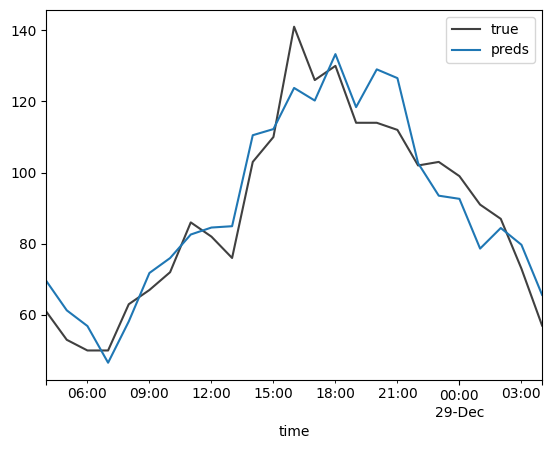

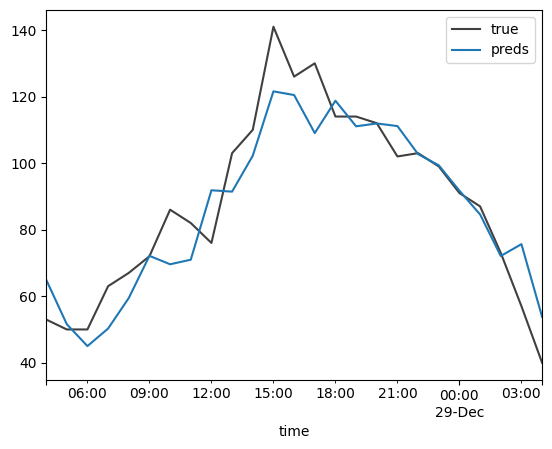

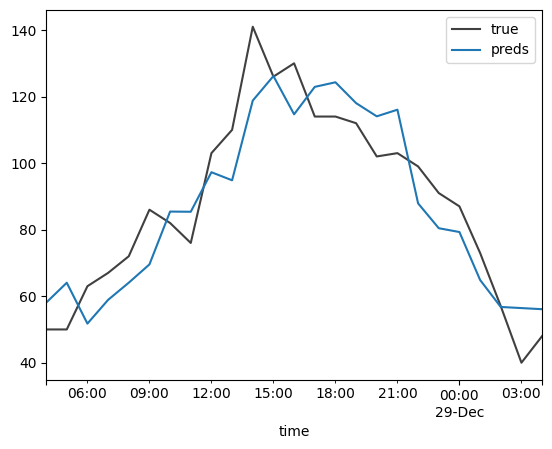

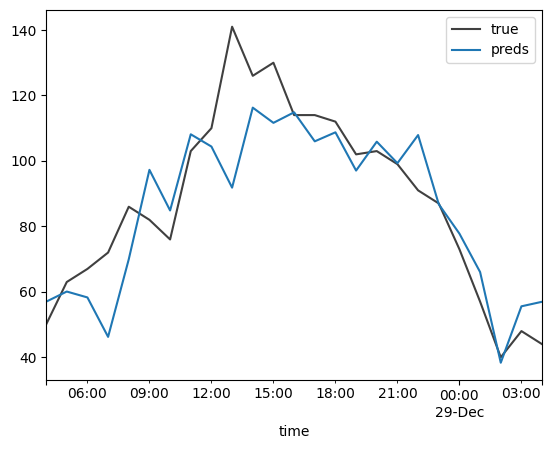

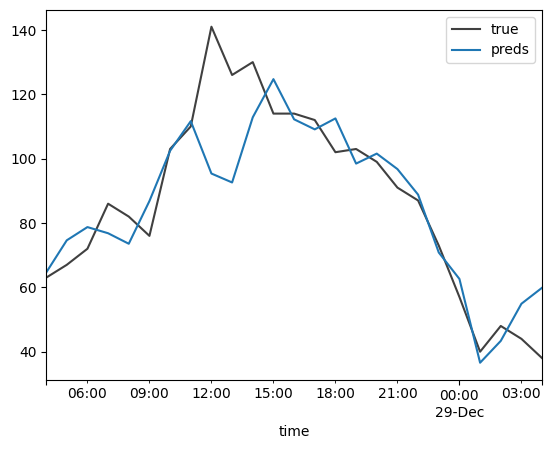

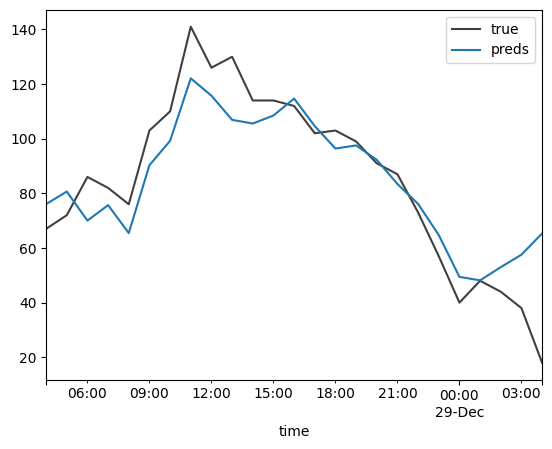

In [31]:
for i in range(y_test.shape[1]):
    plot_preds_vs_true(y_test.iloc[:,i], y_final_preds_optimized.iloc[:,i])
    plt.show()

In [32]:
mae_list_final = []

for i in range(y_resid_test.shape[0]):
    mae_list_final.append(mean_absolute_error(y_test.iloc[i,:], 
                                              y_final_preds_optimized.iloc[i,:]))
print(f"Average mae is {np.array(mae_list_final).mean():.2f}")

Average mae is 9.04


### Total User Models

In [87]:
multi_index = df.index.append(df.iloc[-24:,:].index+dt.timedelta(days=1))

In [108]:
dp_multi = DeterministicProcess(
    index=multi_index,
    constant=True,
    order=1,
    drop=True,
    fourier=2
)

X_multi = dp_multi.in_sample()

In [109]:
X_multi_train = X_multi.iloc[:169,:]
X_multi_test = X_multi.iloc[169:,:]

model_multi = LinearRegression(fit_intercept=False)
model_multi.fit(X_multi_train, df.iloc[:169,0])

preds = pd.DataFrame(model_multi.predict(X_multi), index=multi_index)

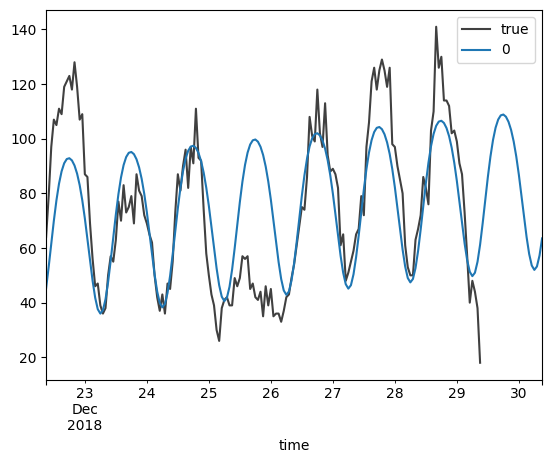

In [110]:
plot_preds_vs_true(df.iloc[:,0], preds)

In [103]:
model_multi.predict(X_multi_test).astype(int)

array([ 69,  77,  85,  93,  99, 104, 107, 108, 108, 108, 106, 103,  99,
        93,  86,  79,  71,  63,  57,  53,  51,  53,  57,  63])